<a href="https://colab.research.google.com/github/aformen9/BC-ML-Project/blob/agu/notebook/BreastCancer_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explicacion teoria
Para este caso de clasificación de tumores (M vs. B) sobre el dataset de Breast Cancer Wisconsin, te recomendaría emplear Regresión Logística y Random Forest. A continuación, un breve razonamiento de por qué estos dos modelos cumplen bien los requisitos del trabajo:

### Regresión Logística

- Ventajas:

Es un modelo lineal sencillo y muy interpretativo: puedes ver directamente el peso que asigna a cada variable (coeficientes), lo cual ayuda a explicar el resultado en lenguaje comprensible para un público no experto.

Suele servir como “baseline” (modelo base) para cualquier tarea de clasificación binaria; si su desempeño es razonable, sabrás que el problema no es extremadamente complejo.

Su entrenamiento es rápido y, al ser lineal, no requiere tanto ajuste de hiperparámetros.

- Aplicación en este dataset:

Permite ver claramente qué características (por ejemplo, el radio medio, la textura media, el área, etc.) tienden a asociarse más con tumores malignos o benignos.

Al graficar la matriz de confusión, podrás ver cuántos casos de cáncer benigno se clasifican correctamente (TN), cuántos falsos negativos (FN), etc., y explicarlo de forma sencilla: “de cada 100 tumores malignos, el modelo detectó X correctamente y falló en Y”.

###Random Forest

- Ventajas:

Es un ensamble de árboles de decisión que combina múltiples “árboles débiles” para obtener un clasificador robusto, capaz de capturar relaciones no lineales y jerarquías complejas entre variables.

Maneja bien la multicolinealidad y las características con diferentes escalas, y suele dar muy buena precisión en problemas de detección de enfermedades.

Permite obtener la importancia de cada variable (feature importance), lo que facilita justificar por qué ciertas medidas celulares (p. ej., concavidad o suavidad) son más relevantes para predecir malignidad.

- Aplicación en este dataset:

Podrás comparar su desempeño (accuracy, recall, precision, AUC) contra la Regresión Logística. Generalmente Random Forest supera al modelo lineal si hay interacciones o patrones complejos entre las características.

Al graficar la matriz de confusión para Random Forest, mostrarás cuántos tumores malignos detectó correctamente frente a cuántos clasificó erróneamente. Además, puedes incluir un mapa de calor de correlaciones o un boxplot/violin para justificar por qué ciertos grupos de variables (por ejemplo, medidas de perímetro o área) son marcadores fuertes y cómo Random Forest las aprovecha.

### (1) Rellenar los valores nulos:
La elección entre imputar valores faltantes con la media o la mediana depende fundamentalmente de la distribución de la variable y de la presencia de outliers (valores atípicos):

**Cuando usar la media**

La media es el promedio aritmético de todos los valores.
Recomendable si la variable tiene una distribución aproximadamente simétrica (por ejemplo, campana de Gauss) y pocos o ningún outlier.

Ventaja: conserva la suma total de los datos y, en distribuciones normales, es el estimador más eficiente (menor varianza).

Desventaja: es muy sensible a valores extremos. Si tienes unos pocos valores muy grandes o muy pequeños, la media se “desplaza” y puede introducir un sesgo.

**Cuando usar la mediana**

La mediana es el valor que queda justo en el centro de la muestra ordenada.
Recomendable si la variable está sesgada (asimétrica) o si existen outliers que podrían distorsionar la media.

Ventaja: es robusta frente a valores extremos; un par de outliers no la afecta.

Desventaja: no preserva necesariamente la suma total de los datos y puede generar un ligero “aplomo” en la distribución si hay muchos faltantes.

**¿De qué depende esta decisión?**

Forma de la distribución:

- Histograma o densidad: si ves un histograma simétrico, la media funciona bien.

- Skewness: si el coeficiente de asimetría (skew) es alto (positiva o negativa), conviene mediana.

- Presencia de outliers:
Si hay valores atípicos significativos (detectados con boxplot o z-score), la mediana es más segura.

- Propósito del análisis:

1. Para modelos que suponen normalidad en las features (p. ej. Regresión Lineal, LDA), a veces conviene media — siempre que no haya outliers fuertes.

2. Para árboles (Decision Tree, Random Forest), la imputación con mediana suele funcionar tan bien o mejor, ya que estos modelos no se ven muy afectados por la escala pero sí por la posición.

### (2) ¿Por qué no elijo Decision Tree como segundo modelo?
- Árbol de Decisión simple:

Aunque es muy interpretable y visual (puedes dibujar el árbol completo), tiende a sobreajustarse con facilidad, sobre todo en datasets con muchas variables numéricas y ruido, como este.

Al incluir Random Forest en lugar de un único árbol, te aseguras de “proteger” esa interpretación de árboles simples contra el sobreajuste, ya que el ensamble promedia múltiples árboles.

Sin embargo, podrías usar Decision Tree como experimento adicional (pues el enunciado lo permite), pero para el entregable final te alcanzan dos modelos: uno lineal (Regresión Logística) y uno no lineal/ensemble (Random Forest).

### Codificar columna binaria:
get_dummies() genera dos columnas binarias (“diagnosis_B” y “diagnosis_M”), una para cada categoría.
En un problema de clasificación binaria, esto tiene varias desventajas:

**Redundancia**

Si sabes que “diagnosis_M” es 1 exactamente cuando “diagnosis_B” es 0, una de las columnas sobra.

Mantener ambas añade información duplicada.

**Dummy variable trap (multicolinealidad)**

En modelos lineales (p. ej. Regresión Logística) dos variables perfectamente inversas generan multicolinealidad, lo que puede desestabilizar los coeficientes.

Para evitarlo tendrías que eliminar una dummy manualmente (drop_first=True), pero entonces vuelves a tener solo una columna, igual que con .map() o replace().

**Complejidad innecesaria**

Para el target binario basta con un único vector 0/1. Usar dummies está pensado más para variables categóricas con más de dos niveles (por ejemplo, “rojo”, “verde”, “azul”), donde necesitas varias columnas.

**Convención y claridad**

Al convertir la variable objetivo, lo estándar es tener una sola columna numérica (0/1). Así tu pipeline y tus métricas esperan directamente un vector de ceros y unos, sin tener que seleccionar “qué columna” de las dummies usar.


Por eso conviene usar .map() / .replace() / LabelEnconder.

Nosotros elegimos .map() en este caso.

### (3) Escalado de Datos

¿Por qué escalamos?

Escalar (o normalizar) las variables numéricas antes de entrenar un modelo de ML sirve para poner todas las features en una misma “unidad de medida”, evitando que aquellas con rangos grandes dominen el proceso de entrenamiento.

Veamos punto por punto:

1. Algoritmos basados en distancias:
Modelos como K-NN, SVM o redes neuronales miden distancias entre puntos en el espacio de features. Si una variable va de 0 a 10 000 y otra de 0 a 1, la primera “pesará” muchísimo más.
2. Convergencia de optimizadores:
En modelos basados en gradiente (Regresión Logística, redes neuronales), tener variables con escalas muy distintas puede hacer que el proceso de optimización sea más lento o inestable.
3. Interpretabilidad de coeficientes:
En Regresión Lineal o Logística, los coeficientes reflejan el cambio en la salida por un cambio de “una unidad” en la feature. Si todas están escaladas, podemos comparar directamente la “importancia” de cada coeficiente.

**¿Por qué StandardScaler?**



```
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
```



- Qué hace: a cada columna le resta la media y divide por la desviación estándar, de modo que la nueva distribución tiene media 0 y varianza 1.
- Ventaja:
Es el escalado “por defecto” cuando sospechamos que las features tienen distribución aproximadamente normal.
Muy útil en algoritmos que asumen datos centrados (p. ej. PCA, modelos basados en covarianzas).

**Otras alternativas y cuándo usarlas:**

Escalador Qué hace	Cuándo usarlo
- MinMaxScaler ->	Reescala cada feature al rango [0,1] o [a,b] configurable -> Cuando quieres conservar la forma de la distribución y los valores estén acotados (p. ej. imágenes)
- RobustScaler ->	Resta la mediana y divide por el IQR (rango intercuartílico) -> Si hay muchos outliers; es más resistente a valores extremos
- MaxAbsScaler -> Divide cada valor por el máximo valor absoluto de su feature, escalando al rango [–1,1] ->	Cuando los datos ya están centrados en cero y quieres mantener signos

- Normalizer ->	Escala cada fila (muestra) para que su norma L1 o L2 sea 1 -> Para algoritmos basados en distancia o similaridad de coseno, cuando importa la dirección más que la magnitud del vector

**¿Cuál es “la mejor”?**

No existe un “mejor” universal, depende de:

Características de tus datos:

- Outliers → prefiere RobustScaler.
- Distribución aproximadamente Gauss → StandardScaler.
- Valores ya acotados o proporciones → MinMaxScaler.

Algoritmo que uses:

- Basados en distancia (K-NN, SVM) → escálalo todo al mismo rango (Standard o MinMax).
- Basados en árbol (Decision Tree, Random Forest) → no requieren escalado estricto, aunque escalar no suele perjudicar.

Interpretabilidad:

Si quieres comparar coeficientes en regresiones, StandardScaler facilita interpretar en desviaciones estándar.

Ejemplo de uso de otros escaladores:




```
from sklearn.preprocessing import MinMaxScaler, RobustScaler
# Min-Max al rango [0,1]
mms = MinMaxScaler()
X_minmax = mms.fit_transform(X)

# Escalado robusto (mediana e IQR)
rbs = RobustScaler()
X_robust = rbs.fit_transform(X)
```


**Resumen:**

1. Escalas para que ninguna feature “tire” del modelo por su magnitud.

2. StandardScaler es el estándar cuando tus datos no tienen outliers muy fuertes y buscas media=0, varianza=1.

3. Si tus variables están muy sesgadas o con outliers, prueba RobustScaler; si quieres rangos fijos, usa MinMaxScaler.

4. Siempre elige el método según la naturaleza de tus datos y el modelo que vayas a entrenar.

### (4) Sintaxis:
```
X = pd.DataFrame(X_scaled, columns=X.columns)
```
```pd.DataFrame(...)```

- ```pd ```es el alias habitual de la librería pandas.
- ```pd.DataFrame(data, columns=…)``` crea un nuevo DataFrame con los datos que le pases en ```data``` y usa la lista ```columns``` para nombrar las columnas.
- ```X_scaled```
Es un array NumPy (o array similar) con la misma forma que el DataFrame original ```X``` (mismo número de filas y columnas), pero cuyos valores han sido transformados (escalados) por el ```StandardScaler```.
Por ejemplo, si ```X``` tenía 100 filas y 30 columnas, ```X_scaled``` es un array de forma (100, 30).

- ```columns=X.columns```
```X.columns``` es un índice de pandas que contiene los nombres originales de las columnas de ```X``` (antes de escalar).
Al pasar ```columns=X.columns```, le decimos al nuevo DataFrame que use esos mismos nombres para cada una de las 30 columnas de ```X_scaled```.
- ```Asignación a X```
Finalmente, ```X = ... ```sobrescribe el DataFrame original ```X``` en tu espacio de trabajo con este nuevo DataFrame escalado.
A partir de aquí, ```X ```sigue siendo un DataFrame de pandas (y no un array de NumPy), lo cual te permite seguir usando métodos de pandas (filtrado, selección de columnas, visualización, etc.).

**¿Por qué es importante?**

- Preservar los nombres de columna: Sin ese parámetro ```columns=```, el DataFrame resultante usaría índices numéricos ```0,1,2,…,``` y perderías el etiquetado descriptivo (por ejemplo, ```"radius_mean"```, ```"texture_mean"```, etc.), lo que dificulta cualquier operación posterior basada en nombres de columnas.

- Interoperabilidad con pandas: Al volver a DataFrame, mantienes la comodidad de pandas (por ejemplo, ```X['radius_mean']``` sigue funcionando), en lugar de tener que trabajar con índices de array de NumPy.

**En resumen:**

1. Entrada: ```X_scaled``` (array NumPy), ```X.columns``` (lista de nombres).
2. Salida: un DataFrame con los datos transformados y los mismos nombres de columnas que el original, asignado de nuevo a la variable ```X```.


# Exploracion del dataset

In [3]:
# Laburamos sobre el repositorio de github:
!git clone https://github.com/aformen9/BC-ML-Project.git
%cd BC-ML-Project

Cloning into 'BC-ML-Project'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 90 (delta 20), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (90/90), 328.96 KiB | 3.07 MiB/s, done.
Resolving deltas: 100% (20/20), done.
/content/BC-ML-Project/BC-ML-Project


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif # Selector y criterio ANOVA F, respectivamente.

In [5]:
cancer_data = pd.read_csv('/content/BC-ML-Project/data/Breast Cancer Wisconsin_TF.csv')
cancer_data.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


In [6]:
# Dimesiones del df; filas y coluknas:
cancer_data.shape

(569, 33)

In [7]:
# Tipo de dato de cada columna:
cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              552 non-null    float64
 3   texture_mean             541 non-null    float64
 4   perimeter_mean           513 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
# Cantidad de valores nulos en el df:
print(f"\nValores nulos por columna:\n \n{cancer_data.isnull().sum()}")


Valores nulos por columna:
 
id                           0
diagnosis                    0
radius_mean                 17
texture_mean                28
perimeter_mean              56
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_d

In [9]:
# Estadisticas descriptivas:
cancer_data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,552.000000,541.000000,513.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.130813,19.314529,91.620351,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.536453,4.329154,24.206004,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.687500,16.180000,74.720000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.415000,18.890000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.797500,21.810000,103.700000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,186.900000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [10]:
# Cantidad total de pacientes analizados:
total_pacientes = len(cancer_data)
print(f"Pacientes totales: {total_pacientes}")

Pacientes totales: 569


In [11]:
# Cantidad de tumeros benignos (B) y malignos (M)
print(cancer_data['diagnosis'].value_counts())
# % de pacientes con tumores benignos y malignos:
porcentaje_B = (357 * 100) / 569
porcentaje_M = (212 * 100) / 569
print(f"Porcentaje de pacientes con tumores benignos: {porcentaje_B:.2f}%")
print(f"Porcentaje de pacientes con tumores malignos: {porcentaje_M:.2f}%")

diagnosis
B    357
M    212
Name: count, dtype: int64
Porcentaje de pacientes con tumores benignos: 62.74%
Porcentaje de pacientes con tumores malignos: 37.26%


In [12]:
# Tipos de datos:
data_type = cancer_data.dtypes
print(f"Tipos de datos por columnas:\n \n{data_type}")

Tipos de datos por columnas:
 
id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst       

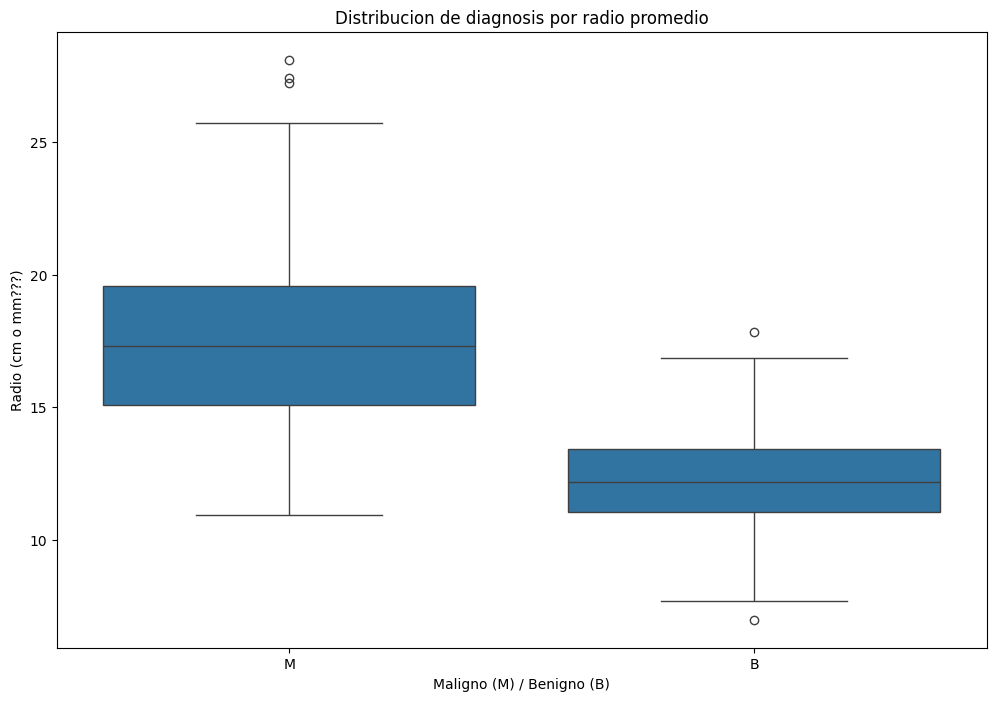

In [13]:
# Relacion entre diagnostico y radio promedio (mm o cm???????):
plt.figure(figsize=(12, 8))
sns.boxplot(x='diagnosis', y='radius_mean', data=cancer_data)
plt.title('Distribucion de diagnosis por radio promedio')
plt.xlabel('Maligno (M) / Benigno (B)')
plt.ylabel('Radio (cm o mm???)')
plt.show()

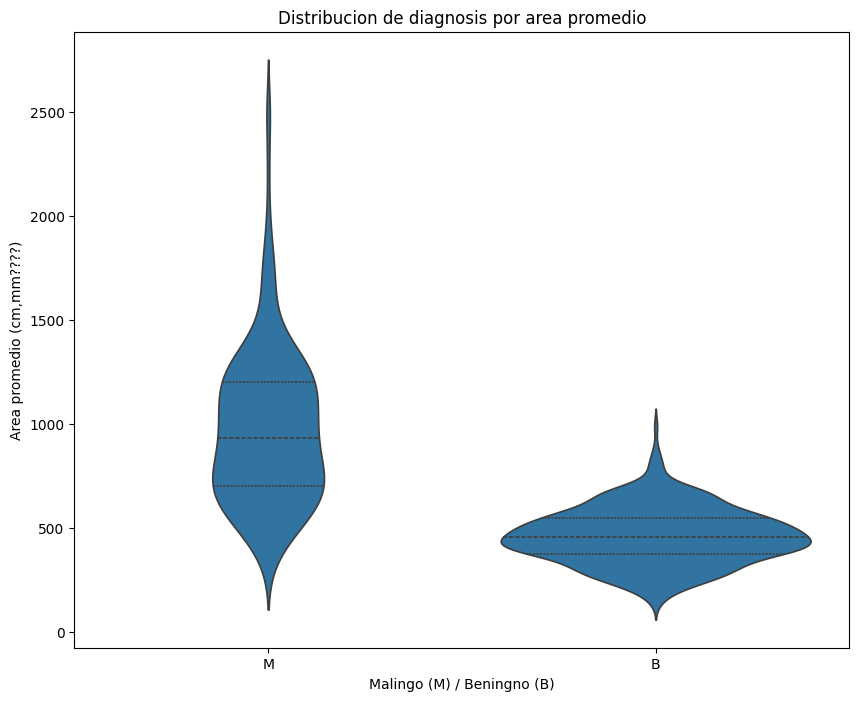

In [14]:
# Relacion entre diagnostico y area promedio (unidad????):
plt.figure(figsize=(10, 8))
sns.violinplot(x="diagnosis",
               y="area_mean",
               data=cancer_data,
               inner="quartile") #inner="quartile" dibuja los cuartiles dentro del violín.
plt.title("Distribucion de diagnosis por area promedio")
plt.xlabel("Malingo (M) / Beningno (B)")
plt.ylabel("Area promedio (cm,mm????)")
plt.show()

# Limpieza y preparacion de los datos

Las columnas 'id' y 'unnamed: 32' son irrelevantes para nuestro modelo.

In [15]:
# Dropeamos las columnas:
df = cancer_data
df = df.drop(['id'], axis=1)
if 'Unnamed: 32' in df.columns:
  df = df.drop(['Unnamed: 32'], axis=1)

In [16]:
# Chequeamos como quedo el df:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
# Cantidad de valores nulos
print(df.isnull().sum())

diagnosis                   0
radius_mean                17
texture_mean               28
perimeter_mean             56
area_mean                   0
smoothness_mean             0
compactness_mean            0
concavity_mean              0
concave points_mean         0
symmetry_mean               0
fractal_dimension_mean      0
radius_se                   0
texture_se                  0
perimeter_se                0
area_se                     0
smoothness_se               0
compactness_se              0
concavity_se                0
concave points_se           0
symmetry_se                 0
fractal_dimension_se        0
radius_worst                0
texture_worst               0
perimeter_worst             0
area_worst                  0
smoothness_worst            0
compactness_worst           0
concavity_worst             0
concave points_worst        0
symmetry_worst              0
fractal_dimension_worst     0
dtype: int64


### Vayamos analizando por columna:

In [18]:
# (1)
# Estadistica descriptica de la columna:
df['radius_mean'].describe()

,radius_mean
count,552.000000
mean,14.130813
std,3.536453
min,6.981000
25%,11.687500
50%,13.415000
75%,15.797500
max,28.110000


In [19]:
# Mediana:
df['radius_mean'].median()

13.415

<Axes: >

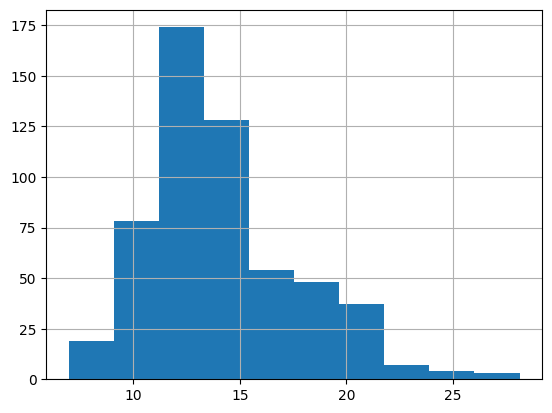

In [20]:
# Histograma:
df['radius_mean'].hist()

In [21]:
# Como la media y la mediana tienen un valor muy cercano,
# y la distribucion de cola (histograma) no es larga, podemos rellenar con la media:
df['radius_mean'] = df['radius_mean'].fillna(df['radius_mean'].mean())

In [22]:
# Chequeamos si siguen habiendo null en la clumna:
df['radius_mean'].isnull().sum()

np.int64(0)

In [23]:
# Vamos con la siguiente columna:
df['texture_mean'].describe()

,texture_mean
count,541.000000
mean,19.314529
std,4.329154
min,9.710000
25%,16.180000
50%,18.890000
75%,21.810000
max,39.280000


In [24]:
# Mediana:
df['texture_mean'].median()

18.89

<Axes: >

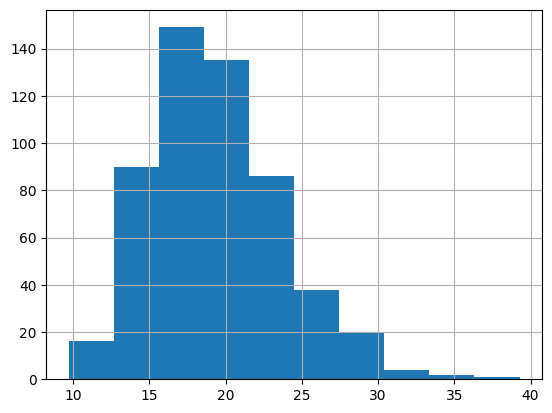

In [25]:
# Histograma:
df['texture_mean'].hist()

In [26]:
# Como la media y la mediana tienen un valor muy cercano,
# y la distribucion de cola (histograma) no es larga, podemos rellenar con la media:
df['texture_mean'] = df['texture_mean'].fillna(df['texture_mean'].mean())

In [27]:
# Chequeamos:
df['texture_mean'].isnull().sum()

np.int64(0)

In [28]:
# Ultima columna con null:
df['perimeter_mean'].describe()

,perimeter_mean
count,513.000000
mean,91.620351
std,24.206004
min,43.790000
25%,74.720000
50%,86.240000
75%,103.700000
max,186.900000


In [29]:
# Mediana:
df['perimeter_mean'].median()

86.24

<Axes: >

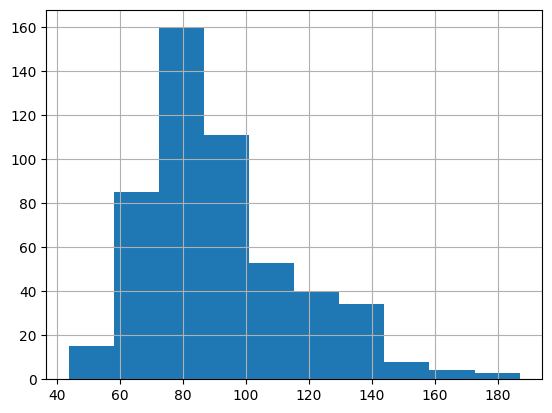

In [30]:
# Histograma:
df['perimeter_mean'].hist()

In [31]:
# Como la media y la mediana tienen un valor muy cercano,
# y la distribucion de cola (histograma) no es larga, podemos rellenar con la media:
df['perimeter_mean'] = df['perimeter_mean'].fillna(df['perimeter_mean'].mean())

In [32]:
# Chequeamos:
df['perimeter_mean'].isnull().sum()

np.int64(0)

In [33]:
# No deberia haber mas valores nulos, chequeamos por ultima vez:
print(df.isnull().sum())

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


### Laburamos la etiqueta:

In [34]:
# Ahora tenemos que codificar la etiqueta:
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1}) # .map() convierte cada 'B' en 0 y cada 'M' en 1. Asi la columna diagnosis pasa de texto a valores numeticos (0/1).
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [35]:
# (2) Con getdummies quedaria asi:
#
#       dummies = pd.get_dummies(df['diagnosis'], prefix='diag') # Creamos el dummies, que tiene DOS columnas: diag_B y diag_M
#
# Pero como es binaria (cuando una es maligna, no es benigna), una sobra, por eso:
#
#     df['diagnosis'] = dummies['diag_M'] # Ahora la columna 'diagnosis' es 1 si es M y 0 si es B.

In [36]:
# Separamos en variables y etiqueta:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [37]:
# (3)
# Escalamos las variables numericas: Usamos StandardScaler, ya que tenemos una distibuicion casi normal, sin outliers pesados. (media = 0; desviacion = 1)
scaler = StandardScaler() # scaler
X_scaled = scaler.fit_transform(X) #fit_transform(X) primero calcula media y desviacion de cada columna (fit) y despiues aplica la transformacion a X (transform), devolviendo un array.
# (4)
X = pd.DataFrame(X_scaled, columns=X.columns) # Reconstruimos X como df con las mismas columnas pero ahora escaladas.
# X.columns es un indice de pandas que tiene los nombres originales de las columnas de X (antes de escalar).

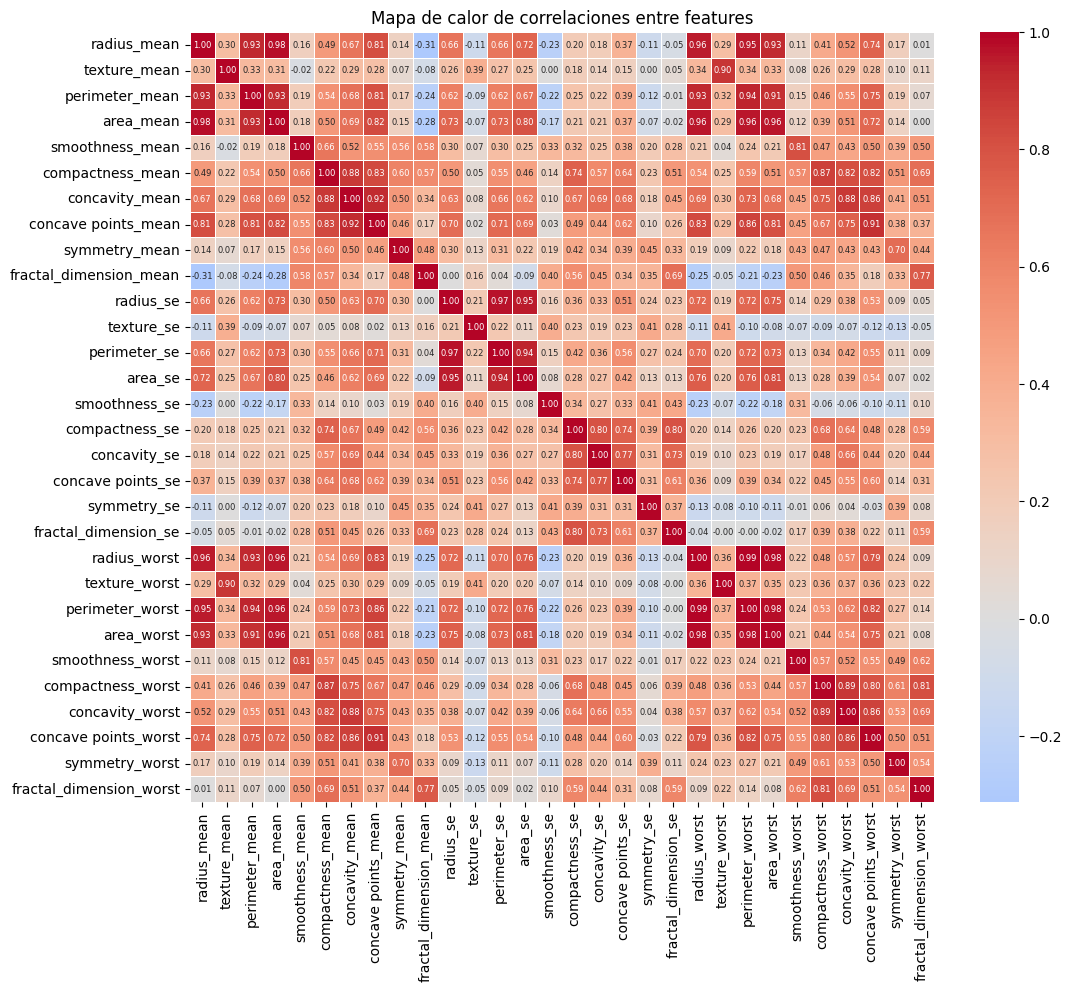

In [44]:
# Mapa de calor:
corr = X.corr() # X.corr() calcula la matriz de correlacion (Pearson) entre todas las variablws. (Investigar!!!)
plt.figure(figsize=(12,10))
sns.heatmap(corr,
            cmap='coolwarm',
            center=0,
            linewidths=0.5,
            annot=True,
            fmt='.2f',
            annot_kws={
                "size":6
            }
            )
#   sns.heatmap(...) dibuja el mapa de calor:
#     - corr: la matriz de correlaciones
#     - cmap='coolwarm': paleta de colores de azul (negativo) a rojo (positivo)
#     - center=0: pone el valor 0 en el centro de la paleta
#     - linewidths=0.5: grosor de lineas entre celdas

plt.title('Mapa de calor de correlaciones entre features')
plt.show()

### Seleccion de data:

La seleccion de datos se puede hacer de forma manual (basada en criterio y exploracion) o automatica (usando un selector: SelectKBest de scikit-learn).

1. La forma manual:
- Se interpreta el heatmap y las distribuciones
- Se buscan pares muy relacionados (p = 1)
- Se decide con cual quedarse (la que medicamente tenga mas sentido en este caso)
- Eliminamos las columnas innecesarias 1 a 1:


```
X_reduced = X.drop(['perimeter_mean', 'radius_se', …], axis=1)
```
Ventajas:
- Interpretabilidad: Elegimos segun nuestro conocimiento del tema
- Control: Nosotros elegimos que si, y que no.
Desventajas:
- Puede estar sesgado
- Escalabilidad baja: "A mano"
- Reproducibilidad baja: Acordarse por que elegimos una u otra.

2. La forma automatica:


```
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
cols_selected = X.columns[selector.get_support()]
X_reduced = X[cols_selected]
```
- ```f_classif```: usa el test ANOVA F para medir la varianza entre clases (diag_B vs diag_M) de cada variable.

- ```k=10```: selecciona las 10 variables con mayor puntaje F.

Ventajas:
- Objetividad: criterio estadistico.
- Rapidez
- Reproducibilidad alta
- Compatibilidad con pipelines: encaja directamente en un flujo de trabajo de scikit-learn.

Desventajas:
- Criterio unico: solo se mide la relacion lineal/varianza, con lo que puede dejar afuera interaciones no lineales.
- Desconocimiento del tema: no incorpora conocimiento biologico (en este caso)
- Riesgo de sobreajuste: si seleccionamos todo el df (en lugar del train set), podemos filtrar caracteristicas basadas en info del test y "vender" un performance demasiado optimista.

Como elegir?
- Pipeline exploratorio o prototipo: ``` SelectKBest``` da un 1er corte objetivo y reproducible.
- Modelo final o informe medico: conviene combinar automatico y manual (revisar que variables quedan, validar con conocimiento del problema) y, a ser posible, hacerlo solo sobre el set de entrenamiento para evitar “mirar” el test.

En resumen:
- Manual = max control e interpretabilidad, pero sesgado y laborioso.
- Automatico = rapido, objetivo y reproducible pero cuidado a no sobreajustar
- Lo ideal es una mezcla de ambos.


In [39]:
print(X.shape)   # debería imprimir (569, n_features)
print(y.shape)   # debería imprimir (569,)

(569, 30)
(569,)


In [40]:
# Automatico
selector = SelectKBest(score_func=f_classif, k=10) # Elegimos las 10 mejores variables basado en ANOVA F (f_classif)
selector.fit(X,y) # Evaluamos cada variable de X con respecto a y.
colum_selec = X.columns[selector.get_support()] # selector.get_support() devuelve un array booleano con True en las variables seleccionadas.
X_reducido = X[colum_selec] # Creamos un df nuevo solo con las columnas seleccionadas.
X_reducido.columns # Imprimimos la lista de las columnas seleccionadas.

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')

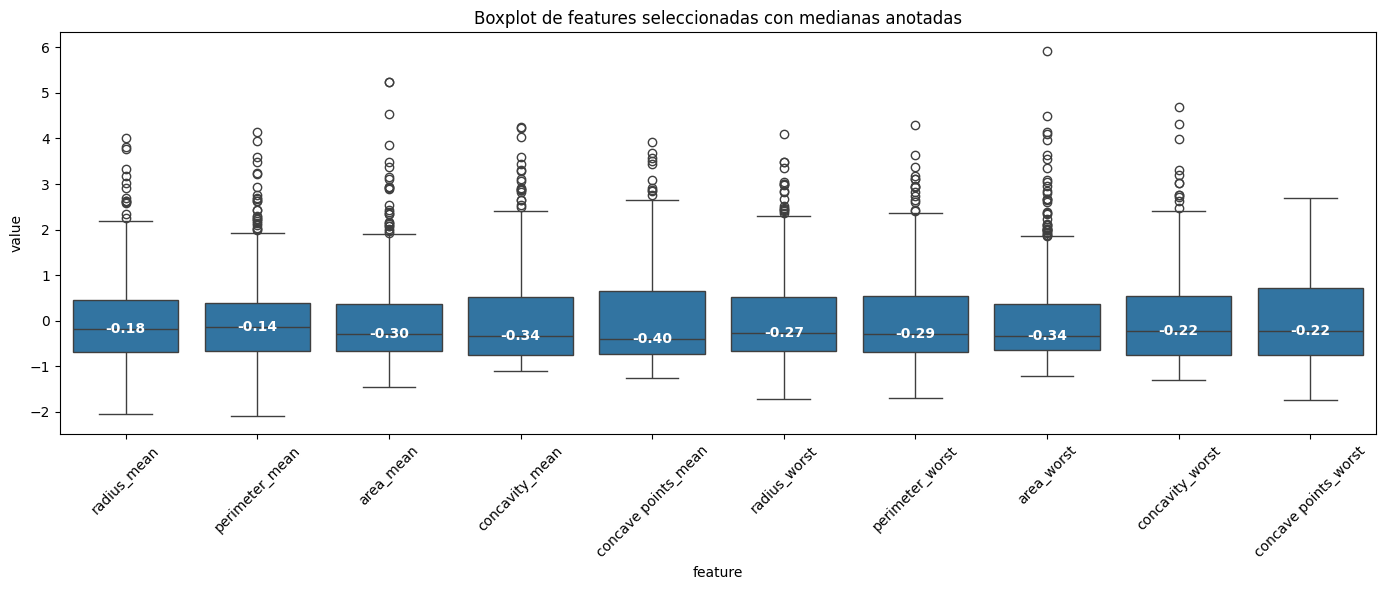

In [45]:
# 1. 'X_reduced' es tu DataFrame con las columnas seleccionadas (shape: [n_muestras, n_features]).
#    Convertimos a formato largo (melt) para que seaborn dibuje un boxplot por feature.
df_melt = X_reducido.melt(var_name='feature', value_name='value')
#    - var_name='feature': nuevo nombre de la columna que contendrá los nombres de las variables.
#    - value_name='value': nuevo nombre de la columna que contendrá los valores.

# 2. Creamos la figura y el axis
plt.figure(figsize=(14,6))
ax = sns.boxplot(x='feature', y='value', data=df_melt)
#    - x='feature': cada categoría en el eje X será una de tus columnas.
#    - y='value': recoge los valores correspondientes.
#    - data=df_melt: le pasamos el DataFrame largo.

# 3. Cálculo de las medianas para cada feature
medians = X_reducido.median()
#    - Esto devuelve una Serie donde index=nombre de la columna, valor=mediana.

# 4. Anotar cada mediana dentro de su caja
for i, feature in enumerate(X_reducido.columns):
    median_val = medians[feature]
    ax.text(
        i,                     # posición X = índice de la caja
        median_val,            # posición Y = valor de la mediana
        f"{median_val:.2f}",   # texto: mediana formateada con 2 decimales
        horizontalalignment='center',
        verticalalignment='center',
        color='white',         # color del texto (elige contraste según paleta)
        weight='bold'
    )

# 5. Ajustes estéticos
plt.xticks(rotation=45)        # gira etiquetas en X para que se lean mejor
plt.title("Boxplot de features seleccionadas con medianas anotadas")
plt.tight_layout()
plt.show()


vamos a tener que estandarizar, despues lo sigo bien. (AGU)!!!